source : https://medium.com/geekculture/different-ways-to-calculate-cosine-similarity-in-python-ae5bb28c372c

In [ ]:
import numpy as np
import pandas as pd

# Load file

In [ ]:
text1 ='''In general, dogs like to eat cats.'''
text2 = '''I saw a dog eating a cat.'''

# Corpus


In [ ]:
corpus = [text1, text2]

# TdIdf Vectorizer


In [ ]:
#see:- https://kanoki.org/2018/12/27/text-matching-cosine-similarity/

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
trsfm=vectorizer.fit_transform(corpus)
pd.DataFrame(trsfm.toarray(),columns=vectorizer.get_feature_names(),index=['doc1','doc2'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,cat,cats,dog,dogs,eat,eating,general,in,like,saw,to
doc1,0.0,0.377964,0.0,0.377964,0.377964,0.0,0.377964,0.377964,0.377964,0.0,0.377964
doc2,0.5,0.000000,0.5,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.5,0.000000


# Cosine similarity - sklearn

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print("cosine similarity :",cosine_similarity(trsfm[0], trsfm)[0][1])

NameError: ignored


# BERT Word Embeddings Tutorial
source : https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#1-loading-pre-trained-bert
## Loading Pre-Trained BERT


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 51.9 MB/s 
     |████████████████████████████████| 3.3 MB 44.3 MB/s 
     |████████████████████████████████| 596 kB 51.6 MB/s 
     |████████████████████████████████| 61 kB 462 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/NLI_contradiction_my_dear_watson/data/translated_data_train.csv")

In [ ]:
df_train.head(5)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,2,3931fbe82a,Little things like these make a huge differenc...,I was trying to accomplish something.,fr,French,0
3,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,4,86aaa48b45,In role playing as well Opportunities to expre...,Children can see how different ethnic groups are.,th,Thai,1


## Input Formatting

###  Special Tokens

In [ ]:
df_train["bert_friendly"] = "[CLS] " + df_train["premise"] + " [SEP] " + df_train["hypothesis"]
df_train.head(5)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,bert_friendly
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[CLS] and these comments were considered in fo...
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[CLS] These are issues that we wrestle with in...
2,2,3931fbe82a,Little things like these make a huge differenc...,I was trying to accomplish something.,fr,French,0,[CLS] Little things like these make a huge dif...
3,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[CLS] you know they can't really defend themse...
4,4,86aaa48b45,In role playing as well Opportunities to expre...,Children can see how different ethnic groups are.,th,Thai,1,[CLS] In role playing as well Opportunities to...


### Tokenization

In [ ]:
df_train["tokens"] = df_train["bert_friendly"].apply(tokenizer.tokenize)

# Map the token strings to their vocabulary indeces.
df_train["tokens_ids"] = df_train["tokens"].apply(tokenizer.convert_tokens_to_ids)

df_train.head(5)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,bert_friendly,tokens,tokens_ids
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[CLS] and these comments were considered in fo...,"[[CLS], and, these, comments, were, considered...","[101, 1998, 2122, 7928, 2020, 2641, 1999, 5675..."
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[CLS] These are issues that we wrestle with in...,"[[CLS], these, are, issues, that, we, wrestle,...","[101, 2122, 2024, 3314, 2008, 2057, 25579, 200..."
2,2,3931fbe82a,Little things like these make a huge differenc...,I was trying to accomplish something.,fr,French,0,[CLS] Little things like these make a huge dif...,"[[CLS], little, things, like, these, make, a, ...","[101, 2210, 2477, 2066, 2122, 2191, 1037, 4121..."
3,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[CLS] you know they can't really defend themse...,"[[CLS], you, know, they, can, ', t, really, de...","[101, 2017, 2113, 2027, 2064, 1005, 1056, 2428..."
4,4,86aaa48b45,In role playing as well Opportunities to expre...,Children can see how different ethnic groups are.,th,Thai,1,[CLS] In role playing as well Opportunities to...,"[[CLS], in, role, playing, as, well, opportuni...","[101, 1999, 2535, 2652, 2004, 2092, 6695, 2000..."


###  Segment ID

In [ ]:
def make_segment(tokenized_sentence):
    sep_idx = tokenized_sentence.index("[SEP]") + 1
    segments_ids = [0] * sep_idx + [1] * (len(tokenized_sentence) - sep_idx)
    return segments_ids

df_train["segments_ids"] = df_train["tokens"].apply(make_segment)
df_train.head(5)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,bert_friendly,tokens,tokens_ids,segments_ids
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[CLS] and these comments were considered in fo...,"[[CLS], and, these, comments, were, considered...","[101, 1998, 2122, 7928, 2020, 2641, 1999, 5675...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[CLS] These are issues that we wrestle with in...,"[[CLS], these, are, issues, that, we, wrestle,...","[101, 2122, 2024, 3314, 2008, 2057, 25579, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,3931fbe82a,Little things like these make a huge differenc...,I was trying to accomplish something.,fr,French,0,[CLS] Little things like these make a huge dif...,"[[CLS], little, things, like, these, make, a, ...","[101, 2210, 2477, 2066, 2122, 2191, 1037, 4121...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[CLS] you know they can't really defend themse...,"[[CLS], you, know, they, can, ', t, really, de...","[101, 2017, 2113, 2027, 2064, 1005, 1056, 2428...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,86aaa48b45,In role playing as well Opportunities to expre...,Children can see how different ethnic groups are.,th,Thai,1,[CLS] In role playing as well Opportunities to...,"[[CLS], in, role, playing, as, well, opportuni...","[101, 1999, 2535, 2652, 2004, 2092, 6695, 2000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Extracting Embeddings
### Running BERT on our text

In [ ]:
# Convert inputs to PyTorch tensors
df_train["tokens_tensors"] = df_train["tokens_ids"].apply(torch.tensor)
df_train["segments_tensors"] = df_train["segments_ids"].apply(torch.tensor)
df_train.head(5)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,bert_friendly,tokens,tokens_ids,segments_ids,tokens_tensors,segments_tensors
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[CLS] and these comments were considered in fo...,"[[CLS], and, these, comments, were, considered...","[101, 1998, 2122, 7928, 2020, 2641, 1999, 5675...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[tensor(101), tensor(1998), tensor(2122), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[CLS] These are issues that we wrestle with in...,"[[CLS], these, are, issues, that, we, wrestle,...","[101, 2122, 2024, 3314, 2008, 2057, 25579, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(101), tensor(2122), tensor(2024), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
2,2,3931fbe82a,Little things like these make a huge differenc...,I was trying to accomplish something.,fr,French,0,[CLS] Little things like these make a huge dif...,"[[CLS], little, things, like, these, make, a, ...","[101, 2210, 2477, 2066, 2122, 2191, 1037, 4121...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(101), tensor(2210), tensor(2477), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
3,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[CLS] you know they can't really defend themse...,"[[CLS], you, know, they, can, ', t, really, de...","[101, 2017, 2113, 2027, 2064, 1005, 1056, 2428...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(101), tensor(2017), tensor(2113), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."
4,4,86aaa48b45,In role playing as well Opportunities to expre...,Children can see how different ethnic groups are.,th,Thai,1,[CLS] In role playing as well Opportunities to...,"[[CLS], in, role, playing, as, well, opportuni...","[101, 1999, 2535, 2652, 2004, 2092, 6695, 2000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[tensor(101), tensor(1999), tensor(2535), tens...","[tensor(0), tensor(0), tensor(0), tensor(0), t..."


In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():
    tokens_tensor = df_train["tokens_tensors"].values[0]
    print(tokens_tensor)
    segments_tensors = df_train["segments_tensors"].values[0]
    print(segments_tensors)
    outputs = model(tokens_tensor,segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]
    # df_train["hidden_states"] = pd.DataFrame(df_train[["tokens_tensors","segments_tensors"]]).apply(lambda x: model(x[0],x[1])[2])
# df_train.head(5)

tensor([ 101, 1998, 2122, 7928, 2020, 2641, 1999, 5675, 3436, 1996, 9455, 3513,
        1012,  102, 1996, 3513, 2764, 1999, 1996, 9455, 2020, 2404, 2362, 2007,
        2122, 7928, 1999, 2568, 1012])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1])


ValueError: ignored

In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
# token_embeddings = torch.stack(hidden_states, dim=0)

# token_embeddings.size()
df_train[]

### Understanding the Output

In [ ]:
pd.DataFrame(df_train[["tokens_tensors","segments_tensors"]]).apply(lambda x : x[0]+x[1])

RuntimeError: ignored

### Creating word and sentence vectors from hidden states

 ### Confirming contextually dependent vectors

### Pooling Strategy & Layer Choice

source : https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1

# BERT For Measuring Text Similarity


In [ ]:
!pip install sentence_transformers

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/NLI_contradiction_my_dear_watson/data/translated_data_train.csv")

In [ ]:
labels = {0 : "entailment",
          1 : "neutral",
          2 : "contradiction"}
df_train["label_str"] = df_train["label"].apply(lambda l : labels[l])

In [ ]:
df_train["both_sentences"] = df_train["premise"].astype(str) + "[SEP]" + df_train["hypothesis"]
df_train["both_sentences"] = df_train["both_sentences"].apply(lambda s : s.split("[SEP]"))

In [ ]:
df_train.head(2)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,both_sentences,sentence_embedding,cosine_similarity,label_str
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[and these comments were considered in formula...,"[[-0.4029379, 0.100926556, 1.3785858, -0.02965...",0.903882,entailment
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[These are issues that we wrestle with in prac...,"[[-0.13798532, 0.7767071, 0.8712658, -0.229236...",0.315600,contradiction


In [ ]:
len(df_train)

12120

In [ ]:
import time
avg_elapsed = 0
i = 0
t_total = time.time()
sentence_embedding = []
for v in df_train["both_sentences"].values :
    t = time.time()
    sentence_embedding.append(model.encode(v))
    i += 1
    avg_elapsed = (avg_elapsed * (i-1) + (time.time() - t)) / i
    if i % 100 == 0 :
        print(str(i).rjust(6),"/",12120)
        print("avg_elapsed :",np.round(avg_elapsed,2),"s. - ETA :",np.round(avg_elapsed * (12120-i),2),"s. - elapsed :",np.round(time.time()-t_total,2),"s.\n")
# df_train["sentence_embedding"] = df_train["both_sentences"].apply(model.encode)

   100 / 12120
avg_elapsed : 0.22 s. - ETA : 2683.18 s. - elapsed : 22.32 s.

   200 / 12120
avg_elapsed : 0.23 s. - ETA : 2690.04 s. - elapsed : 45.14 s.

   300 / 12120
avg_elapsed : 0.22 s. - ETA : 2645.88 s. - elapsed : 67.16 s.

   400 / 12120
avg_elapsed : 0.22 s. - ETA : 2601.34 s. - elapsed : 88.79 s.

   500 / 12120
avg_elapsed : 0.22 s. - ETA : 2602.59 s. - elapsed : 112.0 s.

   600 / 12120
avg_elapsed : 0.24 s. - ETA : 2814.41 s. - elapsed : 146.6 s.

   700 / 12120
avg_elapsed : 0.25 s. - ETA : 2900.79 s. - elapsed : 177.83 s.

   800 / 12120
avg_elapsed : 0.26 s. - ETA : 2897.32 s. - elapsed : 204.78 s.

   900 / 12120
avg_elapsed : 0.26 s. - ETA : 2863.69 s. - elapsed : 229.73 s.

  1000 / 12120
avg_elapsed : 0.26 s. - ETA : 2846.35 s. - elapsed : 255.99 s.

  1100 / 12120
avg_elapsed : 0.26 s. - ETA : 2869.74 s. - elapsed : 286.48 s.

  1200 / 12120
avg_elapsed : 0.27 s. - ETA : 2903.97 s. - elapsed : 319.14 s.

  1300 / 12120
avg_elapsed : 0.27 s. - ETA : 2895.82 s. - 

In [ ]:
df_train["sentence_embedding"] = sentence_embedding
df_train.head(5)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,both_sentences,sentence_embedding
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[and these comments were considered in formula...,"[[-0.4029379, 0.100926556, 1.3785858, -0.02965..."
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[These are issues that we wrestle with in prac...,"[[-0.13798532, 0.7767071, 0.8712658, -0.229236..."
2,2,3931fbe82a,Little things like these make a huge differenc...,I was trying to accomplish something.,fr,French,0,[Little things like these make a huge differen...,"[[0.2809696, -0.08428153, 1.0895385, 0.0316185..."
3,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[you know they can't really defend themselves ...,"[[0.39880043, 0.92766297, 0.88496846, 0.406922..."
4,4,86aaa48b45,In role playing as well Opportunities to expre...,Children can see how different ethnic groups are.,th,Thai,1,[In role playing as well Opportunities to expr...,"[[-0.52123713, -0.21678175, 0.6274934, 0.62343..."


In [ ]:
df_train.to_csv("/content/drive/MyDrive/NLI_contradiction_my_dear_watson/data/df_translated_train.csv")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
df_train["cosine_similarity"] = df_train["sentence_embedding"].apply(lambda x : cosine_similarity(x[0].reshape(1,-1),x[1].reshape(1,-1))[0][0])

In [ ]:
df_train.head(5)

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,both_sentences,sentence_embedding,cosine_similarity
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[and these comments were considered in formula...,"[[-0.4029379, 0.100926556, 1.3785858, -0.02965...",0.903882
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[These are issues that we wrestle with in prac...,"[[-0.13798532, 0.7767071, 0.8712658, -0.229236...",0.315600
2,2,3931fbe82a,Little things like these make a huge differenc...,I was trying to accomplish something.,fr,French,0,[Little things like these make a huge differen...,"[[0.2809696, -0.08428153, 1.0895385, 0.0316185...",0.684313
3,3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[you know they can't really defend themselves ...,"[[0.39880043, 0.92766297, 0.88496846, 0.406922...",0.808631
4,4,86aaa48b45,In role playing as well Opportunities to expre...,Children can see how different ethnic groups are.,th,Thai,1,[In role playing as well Opportunities to expr...,"[[-0.52123713, -0.21678175, 0.6274934, 0.62343...",0.796260


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

[]

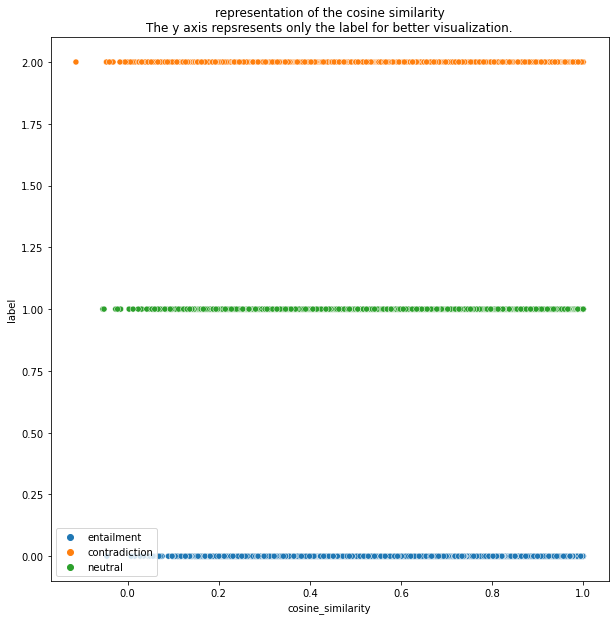

In [ ]:


plt.figure(figsize=(10,10))
plt.title("representation of the cosine similarity\nThe y axis repsresents only the label for better visualization.")
sns.scatterplot(x=df_train["cosine_similarity"], y=df_train["label"], hue=df_train["label_str"])
plt.legend()
plt.plot()